## Collaborative Filetering

#### In this tutorial, we will implement the most native approaches for computing Collaborative Filtering Recommendation system

In [5]:
import pandas as pd
import numpy as np
from sklearn import datasets
import sklearn
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [1]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse 
class CF(object):
    """docstring for CF"""
    def __init__(self, Y_data, k, dist_func = cosine_similarity, uuCF = 1):
        ### Y_data is the rating matrix
        ### k is the number of neibors
        ### dist funct is what we used to measure similarity
        ### user profiles in U-U is now the rating grades itself
        self.uuCF = uuCF # user-user (1) or item-item (0) CF
        self.Y_data = Y_data if uuCF else Y_data[:, [1, 0, 2]]
        self.k = k
        self.dist_func = dist_func
        self.Ybar_data = None
        # number of users and items. Remember to add 1 since id starts from 0
        self.n_users = int(np.max(self.Y_data[:, 0])) + 1 
        self.n_items = int(np.max(self.Y_data[:, 1])) + 1
    
    def add(self, new_data):
        """
        Update Y_data matrix when new ratings come.
        For simplicity, suppose that there is no new user or item.
        """
        self.Y_data = np.concatenate((self.Y_data, new_data), axis = 0)
    
    def normalize_Y(self):
        ##  normalize by substracting avg rating to user profiles
        users = self.Y_data[:, 0] # all users - first col of the Y_data
        self.Ybar_data = self.Y_data.copy()
        self.mu = np.zeros((self.n_users,))
        for n in range(self.n_users):
            # row indices of rating done by user n
            # since indices need to be integers, we need to convert
            ids = np.where(users == n)[0].astype(np.int32)
            # indices of all ratings associated with user n
            item_ids = self.Y_data[ids, 1] 
            # and the corresponding ratings 
            ratings = self.Y_data[ids, 2]
            # take mean
            m = np.mean(ratings) 
            if np.isnan(m):
                m = 0 # to avoid empty array and nan value
            self.mu[n] = m
            # normalize
            self.Ybar_data[ids, 2] = ratings - self.mu[n]

        self.Ybar = sparse.coo_matrix((self.Ybar_data[:, 2],
            (self.Ybar_data[:, 1], self.Ybar_data[:, 0])), (self.n_items, self.n_users))
        self.Ybar = self.Ybar.tocsr()

    def similarity(self):
        eps = 1e-6
        self.S = self.dist_func(self.Ybar.T, self.Ybar.T)
    
        
    def refresh(self):
        """
        Normalize data and calculate similarity matrix again (after
        some few ratings added)
        """
        self.normalize_Y()
        self.similarity() 
        
    def fit(self):
        self.refresh()
        
    
    def __pred(self, u, i, normalized = 1):
        """ 
        predict the rating of user u for item i (normalized) using User-user method
        if you need the un
        """
        # Step 1: find all users who rated i
        ids = np.where(self.Y_data[:, 1] == i)[0].astype(np.int32)
        # Step 2: 
        users_rated_i = (self.Y_data[ids, 0]).astype(np.int32)
        # Step 3: find similarity btw the current user and others 
        # who already rated i
        sim = self.S[u, users_rated_i]
        # Step 4: find the k most similarity users
        a = np.argsort(sim)[-self.k:] 
        # and the corresponding similarity levels
        nearest_s = sim[a]
        # How did each of 'near' users rated item i
        r = self.Ybar[i, users_rated_i[a]]
        if normalized:
            # add a small number, for instance, 1e-8, to avoid dividing by 0
            return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8)

        return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8) + self.mu[u]
    
    def pred(self, u, i, normalized = 1):
        """ 
        predict the rating of user u for item i (normalized) using ITEM-ITEM method
        if you need the un
        """
        if self.uuCF: return self.__pred(u, i, normalized)
        return self.__pred(i, u, normalized)
            
    
    def recommend(self, u,items):
        """
        Determine all items should be recommended for user u.
        The decision is made based on all i such that:
        self.pred(u, i) > 0. Suppose we are considering items which 
        have not been rated by u yet. 
        """
        ids = np.where(self.Y_data[:, 0] == u)[0]
        
        items_rated_by_u = self.Y_data[ids, 1].tolist()    
        recommended_items = []
        ratings = []
        for i in range(self.n_items):
            if i not in items_rated_by_u:
                rating = self.__pred(u, i)
                if rating > 0: 
                    ratings.append(rating)
                    recommended_items.append(i)
        # find top k movie
        if (self.uuCF):
            idx = np.argsort(ratings)[-5:] #idx in the movie id list
            recommended_items = np.array(recommended_items)
            print(idx)
            print(recommended_items)
            idx = recommended_items[idx]
            title = items.values[idx-1,1]
            return title
        return recommended_items 

    def print_recommendation(self,uid,items):
        """
        print all items which should be recommended for each user 
        """
        print ('Recommendation: ')
       
        recommended_items = self.recommend(uid,items)
        if self.uuCF:
            print ('Recommend item(s):', recommended_items, 'for user', uid)
        else: 
            print ('Recommend item', uid, 'for user(s) : ', recommended_items)

#### 1. The dataset

MovieLens 100K movie ratings. Stable benchmark dataset. 100,000 ratings from 1000 users on 1700 movies. Released 4/1998.

README.txt


ml-100k.zip (size: 5 MB, checksum)


Index of unzipped files


Permalink: https://grouplens.org/datasets/movielens/100k/

In [2]:
# download the dataset
import urllib.request
urllib.request.urlretrieve("https://files.grouplens.org/datasets/movielens/ml-100k.zip", "ml-100k.zip")
# unzip the file to directory "data"
import zipfile
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

In [3]:
# important paths
PATH_TO_DATA = "data/ml-100k/"
SUBPATH_ITEM = "u.item"
SUBPATH_TRAINING = "ub.base" # utility matrix for training
SUBPATH_TEST = "ub.test" # utility matrix for training

#### 2. Insights of Data and Utility Matrix

In [6]:
# read the utility matrix:
cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
u_train = pd.read_csv(PATH_TO_DATA+SUBPATH_TRAINING, sep='\t', names=cols)
u_test = pd.read_csv(PATH_TO_DATA+SUBPATH_TEST, sep='\t',names=cols)

number of train samples:  90570
number of test samples:  9430
Unique rating values:  [5 3 4 1 2]
distribution of rating among dataset
   rating  count
0       1   5585
1       2  10340
2       3  24700
3       4  30952
4       5  18993


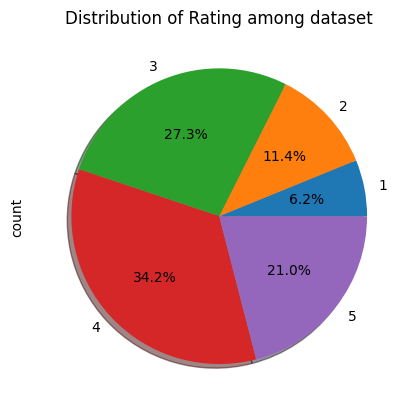

number of unique users:  943
on average each user voted X number of items, X= 96.04453870625663
top 10 user id who voted the most: 
     user_id  count
404      405    727
654      655    675
12        13    626
449      450    530
275      276    508
415      416    483
536      537    480
302      303    474
233      234    470
392      393    438


In [7]:
nb_train = u_train.shape[0]
nb_test = u_test.shape [0]

## basic stats
print("number of train samples: ",nb_train)
print("number of test samples: ",nb_test)
## rating stats
print("Unique rating values: ",u_train.rating.unique())
rating_stat = u_train.groupby("rating").movie_id.agg('count').to_frame('count').reset_index()
print("distribution of rating among dataset")
print(rating_stat)
plot =rating_stat.plot.pie(y = "count",title="Distribution of Rating among dataset", legend=False, \
                   autopct='%1.1f%%', labels = rating_stat.rating.to_list(),
                   shadow=True, startangle=0)
plt.show()
## user stats
count_group = u_train.groupby("user_id").rating.count()

print("number of unique users: ",len(u_train.user_id.unique()))
print("on average each user voted X number of items, X=",np.mean(count_group))
count_group = count_group.reset_index(name='count').sort_values(['count'], ascending=False).head(10)
print("top 10 user id who voted the most: ")
print(count_group)

In [8]:
utility_train = u_train.pivot(index='movie_id', columns='user_id', values='rating')
print("plotting first 10 user's rating for first 10 movies")
print(utility_train.iloc[:10,:10])
nb_nans = (np.count_nonzero(np.isnan(utility_train.iloc[:10,:10])))
## calculate spasity as % of nans elements
print("current sparsity = ",nb_nans/100)
## calculate sparsity for the whole matrix
nb_nans = (np.count_nonzero(np.isnan(utility_train)))
print("Training set sparsity = ",nb_nans/(utility_train.shape[0]*utility_train.shape[1]))



plotting first 10 user's rating for first 10 movies
user_id    1    2   3   4    5    6    7   8    9    10
movie_id                                               
1         5.0  4.0 NaN NaN  4.0  4.0  NaN NaN  NaN  4.0
2         3.0  NaN NaN NaN  3.0  NaN  NaN NaN  NaN  NaN
3         4.0  NaN NaN NaN  NaN  NaN  NaN NaN  NaN  NaN
4         3.0  NaN NaN NaN  NaN  NaN  5.0 NaN  NaN  4.0
5         3.0  NaN NaN NaN  NaN  NaN  NaN NaN  NaN  NaN
6         5.0  NaN NaN NaN  NaN  NaN  NaN NaN  5.0  NaN
7         4.0  NaN NaN NaN  NaN  2.0  5.0 NaN  4.0  4.0
8         1.0  NaN NaN NaN  NaN  4.0  5.0 NaN  NaN  NaN
9         5.0  NaN NaN NaN  NaN  4.0  5.0 NaN  NaN  4.0
10        3.0  2.0 NaN NaN  NaN  NaN  4.0 NaN  NaN  NaN
current sparsity =  0.71
Training set sparsity =  0.942659976891787


#### 3. Preparing the Data

In [13]:
## define the features of items
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

items = pd.read_csv(PATH_TO_DATA+SUBPATH_ITEM, sep='|', names=i_cols, encoding='latin-1')

In [9]:
rate_train = u_train.values
rate_test = u_test.values
# indices start from 0
rate_train[:, :2] -= 1
rate_test[:, :2] -= 1

#### 4. Training and Prediction

In [17]:
## create the model and fitting using User-User approach

### calculate the RMSE

n_tests = u_test.values.shape[0]
SE = 0 # squared error
for n in range(n_tests):
    pred = rs.pred(u_test.values[n, 0],  u_test.values[n, 1], normalized = 0)
    SE += (pred -  u_test.values[n, 2])**2 

RMSE = np.sqrt(SE/n_tests)
print ('User-user CF, RMSE =', RMSE)

User-user CF, RMSE = 0.9951981100882598


In [11]:
## create the model and fitting using Item-Item approach

### calculate the RMSE
n_tests = u_test.values.shape[0]
SE = 0 # squared error
for n in range(n_tests):
    pred = rs.pred(u_test.values[n, 0], u_test.values[n, 1], normalized = 0)
    SE += (pred - u_test.values[n, 2])**2 

RMSE = np.sqrt(SE/n_tests)
print ('Item-item CF, RMSE =', RMSE)

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Item-item CF, RMSE = 0.9867912132705384


In [ ]:
rs.print_recommendation(1,items)

In [ ]:
rs.print_recommendation(1,items)